In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-multi-head
!pip install keras-self-attention

In [ ]:
import keras
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer




import tensorflow as tf
#from model import AttentionResNet
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/PROJECT/codes

In [ ]:
from features import *
from helper import *

In [ ]:
code_path = "/content/drive/MyDrive/Colab Notebooks/PROJECT/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [ ]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [ ]:
mocap_rot = []

for ses_mod in data2:
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))  
    x_rot[np.isnan(x_rot)]=0
    mocap_rot.append( x_rot )
    
mocap_rot = np.array(mocap_rot)
mocap_rot.shape

(4936, 200, 165)

In [ ]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(Y,emotions_used)

Y.shape

(4936, 4)

In [ ]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [ ]:
xtrain_mocap_rot = mocap_rot[:3838]
xtest_mocap_rot = mocap_rot[3838:]
ytrain_mocap_rot = Y[:3838]
ytest_mocap_rot = Y[3838:]

print(xtrain_mocap_rot.shape)
print(xtest_mocap_rot.shape)

print(ytrain_mocap_rot.shape)
print(xtest_mocap_rot.shape)

(3838, 200, 165)
(1098, 200, 165)
(3838, 4)
(1098, 200, 165)


#**Model_rot 1**

In [ ]:
def gru_model_rot1(optimizer='Adam'):
    model = Sequential()
    model.add(GRU(1024, activation='relu', return_sequences=True, input_shape=(200, 165)))
    model.add(GRU(512, activation='relu', return_sequences=True))
    model.add(GRU(256, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model_rot1()
model.summary()

hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 200, 1024)         3658752   
_________________________________________________________________
gru_4 (GRU)                  (None, 200, 512)          2362368   
_________________________________________________________________
gru_5 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_3 (Activation)    (None, 4)                

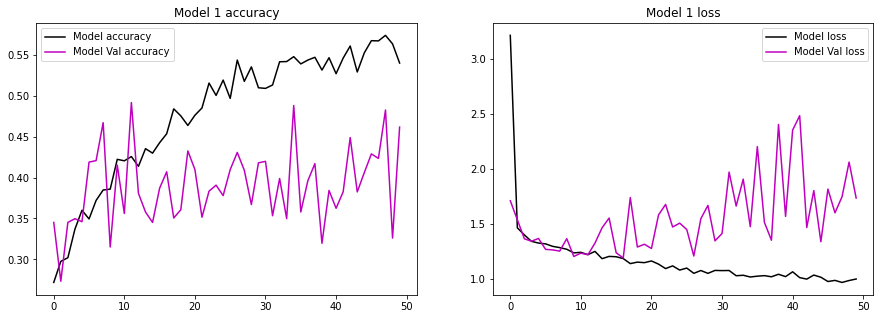

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.96962 dan Training Accuracy 58.21%
Validation Loss 1.73647 dan Validation Accuracy 46.17%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.79      0.30      0.43       933
         exc       0.74      0.64      0.69       742
         neu       0.58      0.45      0.51      1324
         sad       0.65      0.31      0.42       839

   micro avg       0.66      0.42      0.51      3838
   macro avg       0.69      0.42      0.51      3838
weighted avg       0.68      0.42      0.50      3838
 samples avg       0.42      0.42      0.42      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.40      0.01      0.02       170
         exc       0.48      0.85      0.62       299
         neu       0.55      0.41      0.47       384
         sad       0.00      0.00      0.00       245

   micro avg       0.51      0.38      0.43      1098
   macro avg       0.36      0.32      0.28      1098
weighted avg       0.39      0.38      0.33      1098
 samples avg       0.38      0.38      0.38      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


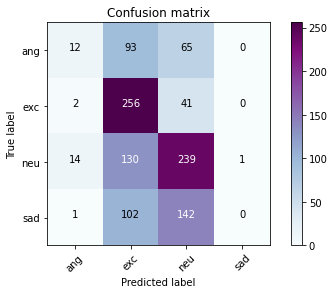

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 2**

In [ ]:
def gru_model_rot2(optimizer='Adam'):
    model = Sequential()
    model.add(GRU(1024, activation='relu', return_sequences=True, input_shape=(200, 165)))
    model.add(SeqSelfAttention(attention_activation='relu'))
    model.add(GRU(512, activation='relu', return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='relu'))
    model.add(GRU(256, activation='relu', return_sequences=False))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = gru_model_rot2()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 200, 1024)         3658752   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 1024)        65601     
_________________________________________________________________
gru_7 (GRU)                  (None, None, 512)         2362368   
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
gru_8 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_4 (Activation)    (None, 256)              

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 45s 1s/step - loss: 4.1015 - accuracy: 0.2697 - val_loss: 1.4087 - val_accuracy: 0.2049
Epoch 2/50
39/39 [==============================] - 42s 1s/step - loss: 1.4101 - accuracy: 0.2974 - val_loss: 1.4489 - val_accuracy: 0.1949
Epoch 3/50
39/39 [==============================] - 43s 1s/step - loss: 1.3854 - accuracy: 0.3246 - val_loss: 1.3185 - val_accuracy: 0.3852
Epoch 4/50
39/39 [==============================] - 43s 1s/step - loss: 1.3837 - accuracy: 0.3154 - val_loss: 1.3640 - val_accuracy: 0.3288
Epoch 5/50
39/39 [==============================] - 42s 1s/step - loss: 1.3417 - accuracy: 0.3351 - val_loss: 1.3040 - val_accuracy: 0.4763
Epoch 6/50
39/39 [==============================] - 42s 1s/step - loss: 1.3223 - accuracy: 0.3832 - val_loss: 1.2446 - val_accuracy: 0.4845
Epoch 7/50
39/39 [==============================] - 42s 1s/step - loss: 1.3354 - accuracy: 0.3554 - val_loss: 1.2252 - val_accuracy: 0.4973
Epoch 8/50
39/39 [==

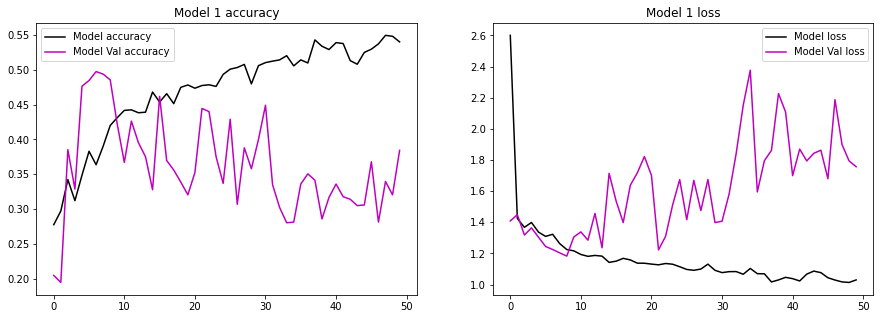

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.01332 dan Training Accuracy 55.60%
Validation Loss 1.75683 dan Validation Accuracy 38.43%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.71      0.35      0.47       933
         exc       0.77      0.55      0.64       742
         neu       0.57      0.31      0.40      1324
         sad       0.82      0.08      0.15       839

   micro avg       0.68      0.32      0.43      3838
   macro avg       0.72      0.32      0.41      3838
weighted avg       0.70      0.32      0.41      3838
 samples avg       0.32      0.32      0.32      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.24      0.08      0.12       170
         exc       0.47      0.85      0.60       299
         neu       0.59      0.15      0.24       384
         sad       0.00      0.00      0.00       245

   micro avg       0.47      0.30      0.36      1098
   macro avg       0.32      0.27      0.24      1098
weighted avg       0.37      0.30      0.27      1098
 samples avg       0.30      0.30      0.30      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


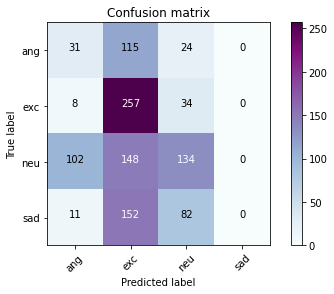

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 3**

In [ ]:
def gru_model_rot3():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 165)))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=False)))
  
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    #print(model.summary())

    return model

In [ ]:
model = gru_model_rot3()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         2085888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          1969152   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 86s 2s/step - loss: 5.6839 - accuracy: 0.2688 - val_loss: 1.3755 - val_accuracy: 0.2741
Epoch 2/50
39/39 [==============================] - 79s 2s/step - loss: 1.4262 - accuracy: 0.3104 - val_loss: 1.3692 - val_accuracy: 0.3470
Epoch 3/50
39/39 [==============================] - 79s 2s/step - loss: 1.3609 - accuracy: 0.3381 - val_loss: 1.2898 - val_accuracy: 0.3889
Epoch 4/50
39/39 [==============================] - 78s 2s/step - loss: 1.3134 - accuracy: 0.3528 - val_loss: 1.3140 - val_accuracy: 0.3069
Epoch 5/50
39/39 [==============================] - 79s 2s/step - loss: 1.2905 - accuracy: 0.3747 - val_loss: 1.2760 - val_accuracy: 0.3953
Epoch 6/50
39/39 [==============================] - 80s 2s/step - loss: 1.3019 - accuracy: 0.3752 - val_loss: 1.3711 - val_accuracy: 0.4089
Epoch 7/50
39/39 [==============================] - 77s 2s/step - loss: 1.2786 - accuracy: 0.3840 - val_loss: 1.2191 - val_accuracy: 0.4608
Epoch 8/50
39/39 [==

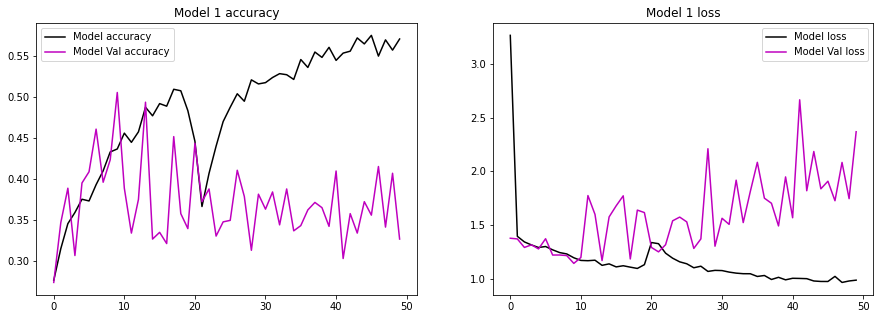

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.03573 dan Training Accuracy 54.04%
Validation Loss 2.36783 dan Validation Accuracy 32.70%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.76      0.28      0.41       933
         exc       0.62      0.76      0.68       742
         neu       0.61      0.28      0.39      1324
         sad       0.82      0.11      0.20       839

   micro avg       0.66      0.34      0.44      3838
   macro avg       0.70      0.36      0.42      3838
weighted avg       0.69      0.34      0.41      3838
 samples avg       0.34      0.34      0.34      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.07      0.01      0.01       170
         exc       0.36      0.91      0.51       299
         neu       0.70      0.08      0.15       384
         sad       0.00      0.00      0.00       245

   micro avg       0.37      0.28      0.32      1098
   macro avg       0.28      0.25      0.17      1098
weighted avg       0.35      0.28      0.19      1098
 samples avg       0.28      0.28      0.28      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


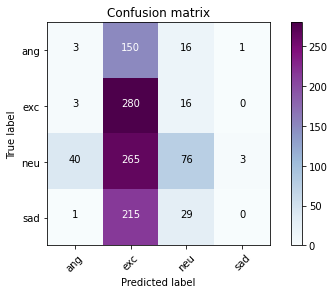

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**Model_rot 4**

In [ ]:
def gru_model_rot4():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 165)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(256, activation="relu", return_sequences=False)))
   
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


    #print(model.summary())

    return model

In [ ]:
model = gru_model_rot4()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         2085888   
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 1024)        65601     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1969152   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 512)         32833     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

In [ ]:
hist = model.fit(xtrain_mocap_rot, ytrain_mocap_rot, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_rot, ytest_mocap_rot))

Epoch 1/50
39/39 [==============================] - 91s 2s/step - loss: 7.3724 - accuracy: 0.2682 - val_loss: 1.4473 - val_accuracy: 0.3424
Epoch 2/50
39/39 [==============================] - 82s 2s/step - loss: 1.4471 - accuracy: 0.3262 - val_loss: 1.3984 - val_accuracy: 0.3497
Epoch 3/50
39/39 [==============================] - 84s 2s/step - loss: 1.3983 - accuracy: 0.3183 - val_loss: 1.3288 - val_accuracy: 0.2860
Epoch 4/50
39/39 [==============================] - 83s 2s/step - loss: 1.3392 - accuracy: 0.3478 - val_loss: 1.2851 - val_accuracy: 0.4599
Epoch 5/50
39/39 [==============================] - 85s 2s/step - loss: 1.2991 - accuracy: 0.3804 - val_loss: 1.2230 - val_accuracy: 0.4872
Epoch 6/50
39/39 [==============================] - 84s 2s/step - loss: 1.2831 - accuracy: 0.3880 - val_loss: 1.2359 - val_accuracy: 0.4772
Epoch 7/50
39/39 [==============================] - 84s 2s/step - loss: 1.2307 - accuracy: 0.4132 - val_loss: 1.2290 - val_accuracy: 0.4053
Epoch 8/50
39/39 [==

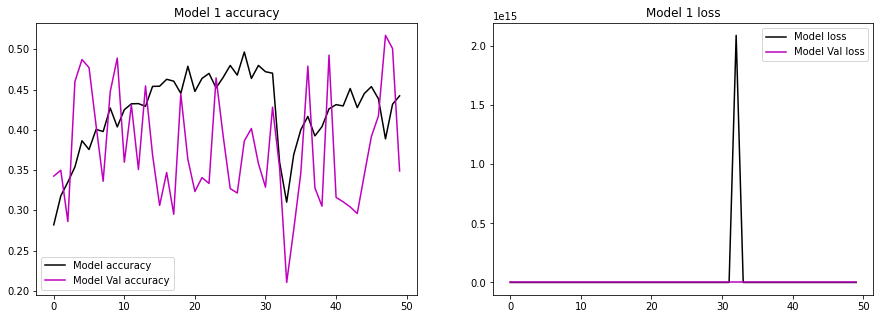

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_rot, ytrain_mocap_rot,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_rot, ytest_mocap_rot,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.14516 dan Training Accuracy 45.10%
Validation Loss 1.51959 dan Validation Accuracy 34.88%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.62      0.13      0.21       933
         exc       0.82      0.42      0.55       742
         neu       0.56      0.02      0.03      1324
         sad       0.81      0.02      0.03       839

   micro avg       0.75      0.12      0.21      3838
   macro avg       0.71      0.14      0.21      3838
weighted avg       0.68      0.12      0.18      3838
 samples avg       0.12      0.12      0.12      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_rot)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_rot, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.23      0.10      0.14       170
         exc       0.57      0.79      0.66       299
         neu       0.57      0.02      0.04       384
         sad       0.00      0.00      0.00       245

   micro avg       0.52      0.24      0.33      1098
   macro avg       0.34      0.23      0.21      1098
weighted avg       0.39      0.24      0.22      1098
 samples avg       0.24      0.24      0.24      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


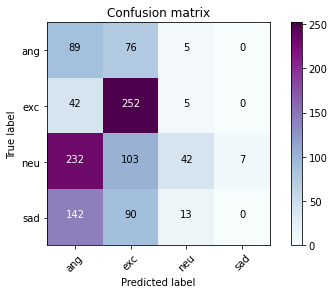

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_rot)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_rot,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MOCAP_COMBINED**

In [ ]:
x_train_mocap = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,18)):
        x_head = np.zeros((200,18))   
    x_head[np.isnan(x_head)]=0
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,6)):
        x_hand = np.zeros((200,6))   
    x_hand[np.isnan(x_hand)]=0
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))   
    x_rot[np.isnan(x_rot)]=0
    x_mocap = np.concatenate((x_head, x_hand), axis=1)
    x_mocap = np.concatenate((x_mocap, x_rot), axis=1)
    x_train_mocap.append( x_mocap )
    
x_train_mocap = np.array(x_train_mocap)
x_train_mocap = x_train_mocap.reshape(-1,200,189,1)
x_train_mocap.shape

(4936, 200, 189, 1)

In [ ]:
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(Y,emotions_used)

Y.shape

(4936, 4)

In [ ]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [ ]:
xtrain_mocap_combined = x_train_mocap[:3838]
xtest_mocap_combined = x_train_mocap[3838:]
ytrain_mocap_combined = Y[:3838]
ytest_mocap_combined = Y[3838:]

print(xtrain_mocap_combined.shape)
print(xtest_mocap_combined.shape)

print(ytrain_mocap_combined.shape)
print(xtest_mocap_combined.shape)

(3838, 200, 189, 1)
(1098, 200, 189, 1)
(3838, 4)
(1098, 200, 189, 1)


In [ ]:
def simple_conv3(optimizer='SGD'):
    model = Sequential()
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same', input_shape=(200, 189, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv3()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 95, 128)      1280      
_________________________________________________________________
dropout (Dropout)            (None, 100, 95, 128)      0         
_________________________________________________________________
activation (Activation)      (None, 100, 95, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 48, 128)       147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 48, 128)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 50, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 24, 128)       1

In [ ]:
hist = model.fit(x_train_mocap, Y, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 13s 225ms/step - loss: 3.6119 - accuracy: 0.2886 - val_loss: 1.3616 - val_accuracy: 0.3694
Epoch 2/50
40/40 [==============================] - 8s 193ms/step - loss: 1.3821 - accuracy: 0.3072 - val_loss: 1.3478 - val_accuracy: 0.3694
Epoch 3/50
40/40 [==============================] - 8s 193ms/step - loss: 1.3730 - accuracy: 0.3164 - val_loss: 1.3480 - val_accuracy: 0.3694
Epoch 4/50
40/40 [==============================] - 8s 193ms/step - loss: 1.3654 - accuracy: 0.3218 - val_loss: 1.3329 - val_accuracy: 0.3694
Epoch 5/50
40/40 [==============================] - 8s 195ms/step - loss: 1.3644 - accuracy: 0.3191 - val_loss: 1.3226 - val_accuracy: 0.4686
Epoch 6/50
40/40 [==============================] - 8s 196ms/step - loss: 1.3395 - accuracy: 0.3529 - val_loss: 1.2832 - val_accuracy: 0.4767
Epoch 7/50
40/40 [==============================] - 8s 197ms/step - loss: 1.3067 - accuracy: 0.3694 - val_loss: 1.2945 - val_accuracy: 0.4757
Epoch

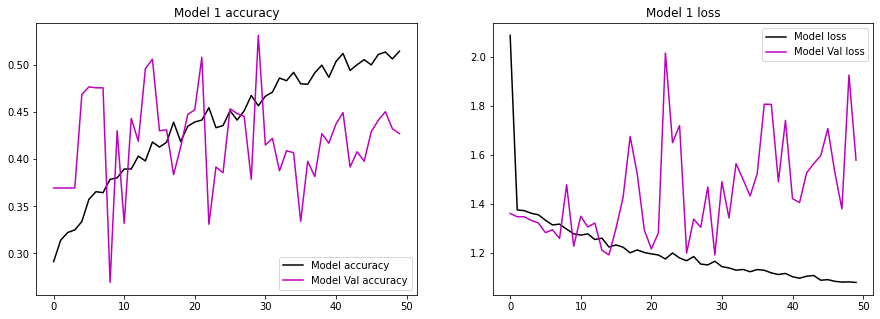

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics
import itertools

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_combined, ytrain_mocap_combined,verbose = 0)
print("Training Loss {:.5f} and Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_combined, ytest_mocap_combined,verbose = 0)
print("Validation Loss {:.5f} and Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.16609 and Training Accuracy 44.82%
Validation Loss 1.48204 and Validation Accuracy 45.90%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_combined)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.94      0.03      0.06       933
         exc       0.83      0.47      0.60       742
         neu       0.65      0.19      0.29      1324
         sad       0.41      0.80      0.55       839

   micro avg       0.53      0.34      0.41      3838
   macro avg       0.71      0.37      0.37      3838
weighted avg       0.70      0.34      0.35      3838
 samples avg       0.34      0.34      0.34      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_combined)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_combined, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       170
         exc       0.55      0.82      0.66       299
         neu       0.64      0.15      0.24       384
         sad       0.35      0.56      0.43       245

   micro avg       0.47      0.40      0.43      1098
   macro avg       0.38      0.38      0.33      1098
weighted avg       0.45      0.40      0.36      1098
 samples avg       0.40      0.40      0.40      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.PRGn):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
      print('Confusion matrix, without normalization')

    cm =np.around(cm, decimals=2)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1
Normalized Confusion Matrix
[[0.   0.43 0.19 0.38]
 [0.   0.82 0.05 0.13]
 [0.   0.21 0.3  0.48]
 [0.   0.27 0.15 0.58]]


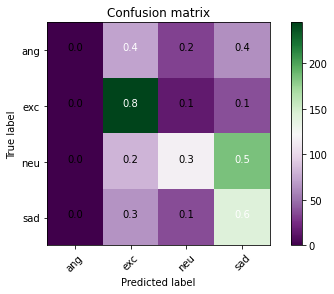

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_combined)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_combined,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 